# Dependencies

In [13]:
import random
from collections import Counter
from statistics import mode
import numpy as np
import pandas as pd
from sklearn import metrics

# Part 1

In [14]:
class Node:
    def __init__(self, feature=None, threshold=None, value=None, left=None, right=None):
        self.feature = feature # feature index
        self.threshold = threshold # feature threshold
        self.value = value # feature index majority
        self.left = left # child nodes
        self.right = right

In [15]:
def tree_grow(x, y, nmin, minleaf, nfeat):
    """
    Grow a decision tree based on the input data

    Args:
        x (list of lists): List of data points
        y (list): List of labels corresponding to data points
        nmin (int): Minimum number of data points required for a node
        minleaf (int): Minimum number of data points required for a leaf node
        nfeat (int): Number of random features to consider for splitting

    Returns:
        Node: Root node of the decision tree
    """

    if pure(y): # if pure return majority class
        return Node(value=mode(y))

    if len(y) < nmin: # if fewer cases than nmin majority class
        return Node(value=mode(y))

    feature, threshold, leftx, rightx, lefty, righty = split(x, y, minleaf, nfeat) # GINI search
    if feature == None: # no split so node becomes leaf
        return Node(value=mode(y))

    left_child = tree_grow(leftx, lefty, nmin, minleaf, nfeat)
    right_child = tree_grow(rightx, righty, nmin, minleaf, nfeat)

    parent = Node()
    parent.feature = feature
    parent.threshold = threshold 
    parent.left = left_child
    parent.right = right_child
    parent.value = mode(y)
    return parent

        
def tree_pred(x, tr):
    """
    Make predictions using a decision tree

    Args:
        x (list of lists): List of data points to make predictions on
        tr (Node): Root node of the decision tree

    Returns:
        list: Predicted labels for the input data points
    """
    predictions = []
    
    for i in range(len(x)):
        current_node = tr
        while current_node.value == None:
            if x[i][current_node.feature] <= current_node.threshold:
                current_node = current_node.left
            else:
                current_node = current_node.right
        predictions.append(current_node.value)
    
    return predictions


def tree_grow_b(x, y, nmin, minleaf, nfeat, m):
    """
    Grow multiple decision trees using bootstrapped samples

    Args:
        x (list of lists): List of data points
        y (list): List of labels corresponding to data points
        nmin (int): Minimum number of data points required for a node
        minleaf (int): Minimum number of data points required for a leaf node
        nfeat (int): Number of random features to consider for splitting
        m (int): Number of trees to grow

    Returns:
        list: List of root nodes of the grown decision trees
    """
    trees = []

    for _ in range(m):
        bootstrap_i = np.random.choice(len(x), len(x), replace=True)
        x_b = [x[i] for i in bootstrap_i]
        y_b = [y[i] for i in bootstrap_i]
        trees.append(tree_grow(x_b, y_b, nmin, minleaf, nfeat))

    return trees


def tree_pred_b(trees, x):
    """
    Make predictions using multiple decision trees

    Args:
        trees (list): List of root nodes of decision trees
        x (list of lists): List of data points to make predictions on

    Returns:
        list: Predicted labels for the input data points
    """
    outcomes = []
    new_y = []
    for tree in trees:
        outcomes.append(tree_pred(x, tree))

    for i in range(len(outcomes[0])):
        new_y.append([a[i] for a in outcomes])
        
    new_y = [mode(a) for a in new_y]
    return new_y

def pure(y):
    """
    Check if all elements in the input list are the same

    Args:
        y (list): List of elements to check.

    Returns:
        bool: True if all elements are the same, otherwise False.
    """
    if len(set(y)) == 1: # if all the same classes in remaining 
        return True
    else:
        return False
    
def gini(y):
    """
    Calculate the Gini impurity for a given list of labels

    Args:
        y (list): List of labels.

    Returns:
        float: Gini impurity value.
    """
    counts = list(Counter(y).values())
    p = 0
    for count in counts:
        p += (count / len(y))**2
    return 1 - p

def split(x, y, minleaf, nfeat):
    """
    Find the best feature and threshold for splitting data points

    Args:
        x (list of lists): List of data points.
        y (list): List of labels corresponding to data points.
        minleaf (int): Minimum number of data points required for a leaf node.
        nfeat (int): Number of random features to consider for splitting.

    Returns:
        tuple: Best feature index, best threshold value,
               left child data points, right child data points,
               left child labels, right child labels.
    """
    features = random.sample(range(len(x[0])), nfeat) # random features selecting
    
    best_gini = 1
    best_feature = None
    best_threshold = None
    best_left_indices = []
    best_right_indices = []

    for feature_index in features:
        values = [a[feature_index] for a in x]
        for t in range(len(values)):
            left_indices = []
            right_indices = []
            right_values = []
            for i, a in enumerate(x): # indices lower than threshold
                if a[feature_index] <= values[t]:
                    left_indices.append(i)
                else:
                    right_indices.append(i)
                    right_values.append(a[feature_index])

            if len(left_indices) >= minleaf and len(right_indices) >= minleaf: # minleaf criteria
                left_gini = gini([y[i] for i in left_indices])
                right_gini = gini([y[i] for i in right_indices])

                weighted_gini = (len(left_indices) / len(y)) * left_gini + (len(right_indices) / len(y)) * right_gini # weighted based on size

                if weighted_gini < best_gini:
                    if weighted_gini == best_gini and random() == 0: ## if gini same and random == 0, skip if random == 1 replace
                        continue
                    best_gini = weighted_gini
                    best_feature = feature_index
                    right_values.sort()
                    best_threshold = (values[t] + right_values[0]) / 2
                    best_left_indices = left_indices
                    best_right_indices = right_indices

    # from indices to rows
    best_left_x = [a for i, a in enumerate(x) if i in best_left_indices]
    best_right_x = [a for i, a in enumerate(x) if i in best_right_indices]
    best_left_y = [a for i, a in enumerate(y) if i in best_left_indices]
    best_right_y = [a for i, a in enumerate(y) if i in best_right_indices]

    return best_feature, best_threshold, best_left_x, best_right_x, best_left_y, best_right_y


In [16]:
file_path = 'data/credit.txt'
df = pd.read_csv(file_path, delimiter=',')
x = df.drop(columns='class').values.tolist()
y = df['class'].values.tolist()

tree = tree_grow_b(x,y, 2, 1, 5, 4)
print(tree_pred_b(tree, x))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [17]:
file_path = 'data/credit.txt'
df = pd.read_csv(file_path, delimiter=',')
x = df.drop(columns='class').values.tolist()
y = df['class'].values.tolist()

tree = tree_grow(x,y, 2, 1, 5)

print('tree prediction on x:')
print('prediction', tree_pred(x,tree))
print('actual y', y)

print()
print()

print('----- node 1 ------')
print('feature', tree.feature)
print('threshold', tree.threshold)
print('----- node 1 - > 2 left -----')
print('feature', tree.left.feature)
print('threshold', tree.left.threshold)
print('value', tree.left.value)
print('----- node 1 -> 2 right -----')
print('feature', tree.right.feature)
print('threshold', tree.right.threshold)
print('value', tree.right.value)
print('----- node 2 -> 3 left -----')
print('feature', tree.left.left.feature)
print('threshold', tree.left.left.threshold)
print('value', tree.left.left.value)
print('----- node 2 -> 3 right -----')
print('feature', tree.left.right.feature)
print('threshold', tree.left.right.threshold)
print('value', tree.left.right.value)

tree prediction on x:
prediction [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
actual y [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


----- node 1 ------
feature 3
threshold 36.0
----- node 1 - > 2 left -----
feature 0
threshold 37.0
value 0
----- node 1 -> 2 right -----
feature None
threshold None
value 1
----- node 2 -> 3 left -----
feature None
threshold None
value 0
----- node 2 -> 3 right -----
feature 3
threshold 31.0
value 1


## boom net niet zelfde als in slides, daar eerste split op feature 3 maar op 36

In [18]:
df = pd.read_csv('data/pima.txt', header=None)
x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

tree = tree_grow(x,y, 20, 5, 8)

cm = metrics.confusion_matrix(y, tree_pred(x, tree))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[500   0]
 [268   0]]


# Part 2

## 2.1: Single Tree

In [19]:
# Load 2.0 Ecplise data as training set 
train_data = pd.read_csv('data/eclipse-metrics-packages-2.0.csv', delimiter=';')

# Load 3.0 Ecplise data as test set
test_data = pd.read_csv('data/eclipse-metrics-packages-3.0.csv', delimiter=';')

In [20]:
# All 41 predictor variables 
pred_variables = ['FOUT_avg', 'FOUT_max', 'FOUT_sum',
                  'MLOC_avg', 'MLOC_max', 'MLOC_sum',
                  'NBD_avg', 'NBD_max', 'NBD_sum',
                  'PAR_avg', 'PAR_max', 'PAR_sum',
                  'VG_avg', 'VG_max', 'VG_sum',
                  'NOF_avg', 'NOF_max', 'NOF_sum',
                  'NOM_avg', 'NOM_max', 'NOM_sum',
                  'NSF_avg', 'NSF_max', 'NSF_sum',
                  'NSM_avg', 'NSM_max', 'NSM_sum',
                  'ACD_avg', 'ACD_max', 'ACD_sum',
                  'NOI_avg', 'NOI_max', 'NOI_sum',
                  'NOT_avg', 'NOT_max', 'NOT_sum',
                  'TLOC_avg', 'TLOC_max', 'TLOC_sum',
                  'NOCU', 'pre']

# Split predictor variables from class labels (training set)
x_train = train_data[pred_variables].values
y_train = [0 if x == 0 else 1 for x in train_data['post']]

# Split predictor variables from class labels (test set)
x_test = test_data[pred_variables].values
y_test = [0 if x == 0 else 1 for x in test_data['post']]

In [29]:
eclipse_tree = tree_grow(x_train, y_train, nmin=15, minleaf=5, nfeat=41)

In [22]:
def visualize_tree(node, depth=0, parent_side=None, st=False):
    if node is not None:
        # Print the node's information with indentation based on its depth in the tree
        indent = "  " * depth
        if parent_side is not None:
            side_label = "Left Child" if parent_side == "left" else "Right Child"
            print(f"{indent}{side_label} - Feature: {node.feature}, Threshold: {node.threshold}, Value: {node.value}")
        else:
            print(f"{indent}Root - Feature: {node.feature}, Threshold: {node.threshold}, Value: {node.value}")
        
        # Recursively visualize the left and right subtrees
        st += 1
        if st < 3:
            visualize_tree(node.left, depth + 1, parent_side="left", st=st)
            visualize_tree(node.right, depth + 1, parent_side="right", st=st)

visualize_tree(eclipse_tree, st=0)


Root - Feature: 40, Threshold: 4.5, Value: 1
  Left Child - Feature: 13, Threshold: 26.5, Value: 0
    Left Child - Feature: 26, Threshold: 54.5, Value: 0
    Right Child - Feature: 14, Threshold: 358.0, Value: 1
  Right Child - Feature: 30, Threshold: 0.1583333333333333, Value: 1
    Left Child - Feature: 40, Threshold: 11.5, Value: 1
    Right Child - Feature: 39, Threshold: 9.5, Value: 1


In [37]:
column_40 = x_train[:, 40]
count = np.sum(column_40 < 4.5)

print(f"Number of items in x_train with a value less than 4.5 in the 40th column: {count}")

column_40 = x_train[:, 40]
count = np.sum(column_40 >= 4.5)

print(f"Number of items in x_train with a value less than 4.5 in the 40th column: {count}")

column_40 = x_train[:, 40]
column_13 = x_train[:, 13]

# Create a boolean mask for the conditions
mask = (column_40 < 4.5) & (column_13 < 26.5)

# Count the number of items that satisfy both conditions
count = np.sum(mask)

print(f"Number of items in x_train where column 40 < 4.5 and column 13 < 26.5: {count}")


column_40 = x_train[:, 40]
column_13 = x_train[:, 13]

# Create a boolean mask for the conditions
mask = (column_40 < 4.5) & (column_13 >= 26.5)

# Count the number of items that satisfy both conditions
count = np.sum(mask)

print(f"Number of items in x_train where column 40 < 4.5 and column 30 >= 0.: {count}")


column_40 = x_train[:, 40]
column_13 = x_train[:, 30]

# Create a boolean mask for the conditions
mask = (column_40 < 4.5) & (column_13 < 0.1583333333333333)

# Count the number of items that satisfy both conditions
count = np.sum(mask)

print(f"Number of items in x_train where column 40 >= 4.5 and column 30 < 0.1583333333333333: {count}")


column_40 = x_train[:, 40]
column_13 = x_train[:, 30]

# Create a boolean mask for the conditions
mask = (column_40 < 4.5) & (column_13 >= 0.1583333333333333)

# Count the number of items that satisfy both conditions
count = np.sum(mask)

print(f"Number of items in x_train where column 40 >= 4.5 and column 30 >= 0.1583333333333333: {count}")

Number of items in x_train with a value less than 4.5 in the 40th column: 214
Number of items in x_train with a value less than 4.5 in the 40th column: 163
Number of items in x_train where column 40 < 4.5 and column 13 < 26.5: 191
Number of items in x_train where column 40 < 4.5 and column 30 >= 0.: 23
Number of items in x_train where column 40 >= 4.5 and column 30 < 0.1583333333333333: 146
Number of items in x_train where column 40 >= 4.5 and column 30 >= 0.1583333333333333: 68


In [41]:
# Step 1: Calculate the sum of both numbers
total = 146 + 68

# Step 2: Calculate the percentage for each number
percentage_214 = (146 / total) * 100
percentage_163 = (68 / total) * 100

print(f"Percentage of 214 in the split: {percentage_214}%")
print(f"Percentage of 163 in the split: {percentage_163}%")

Percentage of 214 in the split: 68.22429906542055%
Percentage of 163 in the split: 31.775700934579437%


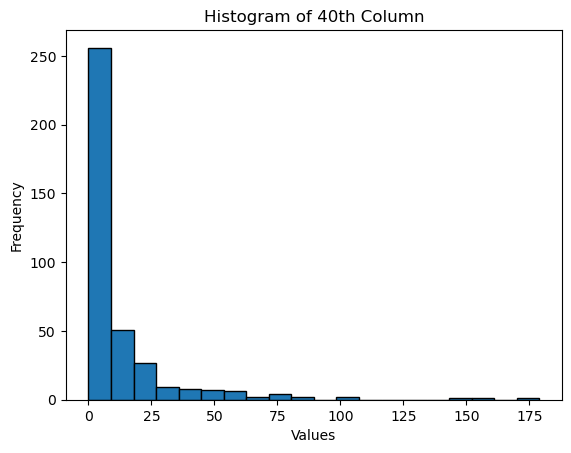

In [43]:
import matplotlib.pyplot as plt

column_40 = x_train[:, 40]

# Create a histogram
plt.hist(column_40, bins=20, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of 40th Column')
plt.show()

In [24]:
print(pred_variables[40])
print(pred_variables[13])
print(pred_variables[30])

pre
VG_max
NOI_avg


In [25]:
cm = confusion_matrix(y_train, tree_pred(x_train, eclipse_tree))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

NameError: name 'confusion_matrix' is not defined

In [ ]:
# Predict on test set
y_pred = tree_pred(x_test, eclipse_tree)
y_true = y_test

# Performance metrics
print('Accuracy: ', metrics.accuracy_score(y_true, y_pred))
print('Precision: ', metrics.precision_score(y_true, y_pred))
print('Recall: ', metrics.recall_score(y_true, y_pred))

Accuracy:  0.6822995461422088
Precision:  0.6928838951310862
Recall:  0.5910543130990416


## 2.2: Bagging

### Itereren over features ipv range(len(features))

In [ ]:
bagged_trees = tree_grow_b(x_train, y_train, nmin=15, minleaf=5, nfeat=41, m=100)

In [ ]:
# Predict on test set
y_pred = tree_pred_b(bagged_trees, x_test)
y_true = y_test

# Performance metrics
print('Accuracy: ', metrics.accuracy_score(y_true, y_pred))
print('Precision: ', metrics.precision_score(y_true, y_pred))
print('Recall: ', metrics.recall_score(y_true, y_pred))

Accuracy:  0.7745839636913767
Precision:  0.8178294573643411
Recall:  0.6741214057507987


### Itereren over range(len(features)) (wat we oorspronkelijk hadden)

In [ ]:
bagged_trees = tree_grow_b(x_train, y_train, nmin=15, minleaf=5, nfeat=41, m=100)

In [ ]:
# Predict on test set
y_pred = tree_pred_b(bagged_trees, x_test)
y_true = y_test

# Performance metrics
print('Accuracy: ', metrics.accuracy_score(y_true, y_pred))
print('Precision: ', metrics.precision_score(y_true, y_pred))
print('Recall: ', metrics.recall_score(y_true, y_pred))

Accuracy:  0.773071104387292
Precision:  0.8221343873517787
Recall:  0.6645367412140575


## 2.3: Random Forest

### Itereren over features ipv range(len(features))

In [ ]:
random_forest = tree_grow_b(x_train, y_train, nmin=15, minleaf=5, nfeat=6, m=100)

In [ ]:
# Predict on test set
y_pred = tree_pred_b(random_forest, x_test)
y_true = y_test

# Performance metrics
print('Accuracy: ', metrics.accuracy_score(y_true, y_pred))
print('Precision: ', metrics.precision_score(y_true, y_pred))
print('Recall: ', metrics.recall_score(y_true, y_pred))

Accuracy:  0.7594553706505295
Precision:  0.7769784172661871
Recall:  0.6900958466453674


### Itereren over range(len(features)) (wat we oorspronkelijk hadden)

In [ ]:
random_forest = tree_grow_b(x_train, y_train, nmin=15, minleaf=5, nfeat=6, m=100)

In [ ]:
# Predict on test set
y_pred = tree_pred_b(random_forest, x_test)
y_true = y_test

# Performance metrics
print('Accuracy: ', metrics.accuracy_score(y_true, y_pred))
print('Precision: ', metrics.precision_score(y_true, y_pred))
print('Recall: ', metrics.recall_score(y_true, y_pred))

Accuracy:  0.649016641452345
Precision:  0.6167146974063401
Recall:  0.6837060702875399


# Tree Visualization